In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score




In [99]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")



In [100]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])



# Data Pre Processing
    -Data Preparation
    -Data cleaning

In [101]:
transaction_features = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum', 
    'TransactionID': 'count', 
    'TransactionDate': lambda x: (pd.Timestamp.now() - x.max()).days 
}).reset_index().rename(columns={
    'TotalValue': 'TotalSpend',
    'TransactionID': 'TransactionCount',
    'TransactionDate': 'Recency'
})

data = customers.merge(transaction_features, on='CustomerID', how='left')
data['Tenure'] = (pd.Timestamp.now() - data['SignupDate']).dt.days


In [102]:
data.fillna({
    'TotalSpend': 0,
    'TransactionCount': 0,
    'Recency': data['Recency'].max(),  
}, inplace=True)


# Encodings
    -One-hot encode 'Region'
    -creating custom features for clustering

In [103]:
data = pd.get_dummies(data, columns=['Region'], drop_first=True)
# Features selection for clustering
features = ['TotalSpend', 'TransactionCount', 'Recency', 'Tenure'] + \
           [col for col in data.columns if col.startswith('Region_')]

#Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])


# K Mean clustering

In [91]:
db_values= []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_values.append(davies_bouldin_score(scaled_features, labels))
k = np.argmin(db_values) + 2
print("Optimal number of clusters: "+str(k))

Optimal number of clusters: 9


In [92]:
kmeans = KMeans(n_clusters=k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluation of the clusters 

In [93]:
# Cluster Evaluation using DB Index as well as silhouette score
db_index = davies_bouldin_score(scaled_features, data['Cluster'])
silhouette = silhouette_score(scaled_features, data['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")


Davies-Bouldin Index: 1.1083878082476688
Silhouette Score: 0.2931144902541474


# Visualization

### Performing PCA for visualization

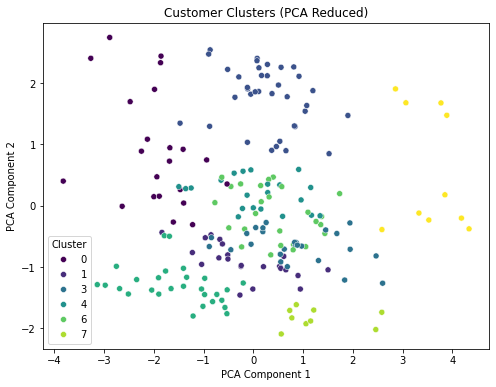

In [96]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()